In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_excel("feature_engineering.xlsx")
df.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,Response,Complain,Age,Year Of Enrollment,Month Of Enrollment,Day Of Enrollment,Household,Total_Spent,Total_Purchases,Total_Visits
0,1826,Graduation,Divorced,84835,0,0,0,189,104,379,...,1,0,54,2014,6,16,0,1190,15,1
1,1,Graduation,Single,57091,0,0,0,464,5,64,...,1,0,63,2014,6,15,0,577,18,5
2,10476,Graduation,Married,67267,0,1,0,134,11,59,...,0,0,66,2014,5,13,1,251,11,2
3,1386,Graduation,Together,32474,1,1,0,10,0,1,...,0,0,57,2014,11,5,2,11,4,7
4,5371,Graduation,Single,21474,1,0,0,6,16,24,...,1,0,35,2014,8,4,1,91,8,7


In [114]:
# We define the encoders first for our categorical variables.
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first=True, prefix=column+suffix)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

from sklearn.preprocessing import LabelEncoder
def one_label_encode(data, column):
    encoder = LabelEncoder()
    data['Label-Encode ' + column] = encoder.fit_transform(data[column])
    data = data.drop(column, axis = 1)
    return data

## Feature Engineering

In [115]:
# We drop first the features that we have profiled to be not helpful to the model with little sample size or little use cases
features = df.drop(columns=['Age', 'Kidhome', 'Teenhome', 'Recency', 'ID', 'MntWines', 'MntFruits', 'MntMeatProducts',
              'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
              'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Month Of Enrollment',
              'Day Of Enrollment'])
features.head()

,Education,Marital_Status,Income,Response,Year Of Enrollment,Household,Total_Spent,Total_Purchases,Total_Visits
0,Graduation,Divorced,84835,1,2014,0,1190,15,1
1,Graduation,Single,57091,1,2014,0,577,18,5
2,Graduation,Married,67267,0,2014,1,251,11,2
3,Graduation,Together,32474,0,2014,2,11,4,7
4,Graduation,Single,21474,1,2014,1,91,8,7


In [116]:
# Since Year of Enrollment could be considered its own label. Let us encode it
# Convert 'Year_of_Enrollment' column to categorical type
features['Year Of Enrollment'] = features['Year Of Enrollment'].astype('category')
features = pd.get_dummies(features, columns=['Year Of Enrollment'], prefix='Year Of Enrollment')
# Also encode Education and Marital_Status
features = one_hot_encode(features, 'Education')
features = one_hot_encode(features, 'Marital_Status')
features.head()

,Income,Response,Household,Total_Spent,Total_Purchases,Total_Visits,Year Of Enrollment_2012,Year Of Enrollment_2013,Year Of Enrollment_2014,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,84835,1,0,1190,15,1,False,False,True,False,True,False,False,False,False,False,False
1,57091,1,0,577,18,5,False,False,True,False,True,False,False,False,True,False,False
2,67267,0,1,251,11,2,False,False,True,False,True,False,False,True,False,False,False
3,32474,0,2,11,4,7,False,False,True,False,True,False,False,False,False,True,False
4,21474,1,1,91,8,7,False,False,True,False,True,False,False,False,True,False,False


## Logistic Regression

In [117]:
from sklearn.model_selection import train_test_split
X = features.drop(columns=['Response'], axis = 1)
y = features['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape
X_train.head()

,Income,Household,Total_Spent,Total_Purchases,Total_Visits,Year Of Enrollment_2012,Year Of Enrollment_2013,Year Of Enrollment_2014,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
1256,33590,3,8,4,72,False,True,False,False,True,False,False,False,False,True,False
483,46015,2,46,5,32,False,False,True,False,False,False,True,False,False,True,False
740,43638,1,201,11,44,True,False,False,False,True,False,False,False,False,False,True
1025,47025,1,415,17,58,False,True,False,False,True,False,False,False,True,False,False
456,42000,0,653,20,28,False,True,False,False,False,False,True,False,True,False,False


In [118]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [119]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver='liblinear', random_state=0)
lg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

## Hyperparameter Optimization

In [121]:
from sklearn.model_selection import GridSearchCV
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = lg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [122]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV best score : 0.8648


Parameters that give the best results : 

 {'penalty': 'l2'}


Estimator that was chosen by the search : 

 LogisticRegression(random_state=0, solver='liblinear')
GridSearch CV score on test set: 0.8475


In [123]:
lg =grid_search.best_estimator_
lg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [124]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
lg_pred = lg.predict(X_test)
lg_acc = accuracy_score(y_test, lg_pred)
lg_prec = precision_score(y_test, lg_pred)
lg_rec = recall_score(y_test, lg_pred)
lg_f1 = f1_score(y_test, lg_pred)
lg_auc = roc_auc_score(y_test, lg_pred)
print("Logistic Regression Accuracy: %.4f" % lg_acc)
print("Logistic Regression Precision: %.4f" % lg_prec)
print("Logistic Regression Recall: %.4f" % lg_rec)
print("Logistic Regression F1: %.4f" % lg_f1)
print("Logistic Regression AUC: %.4f" % lg_auc)
# Check for overfitting
print('Training set score: {:.4f}'.format(lg.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(lg.score(X_test, y_test)))

Logistic Regression Accuracy: 0.8475
Logistic Regression Precision: 0.5312
Logistic Regression Recall: 0.1889
Logistic Regression F1: 0.2787
Logistic Regression AUC: 0.5790
Training set score: 0.8692
Test set score: 0.8475


In [126]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lg, X_train, y_train, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean())) # lower CV score = does not result in improved performance

Cross-validation scores:[0.87037037 0.866171   0.86245353 0.85873606 0.866171  ]
Average cross-validation score: 0.8648


Confusion matrix

 [[472  15]
 [ 73  17]]

True Positives(TP) =  472

True Negatives(TN) =  17

False Positives(FP) =  15

False Negatives(FN) =  73


<Axes: >

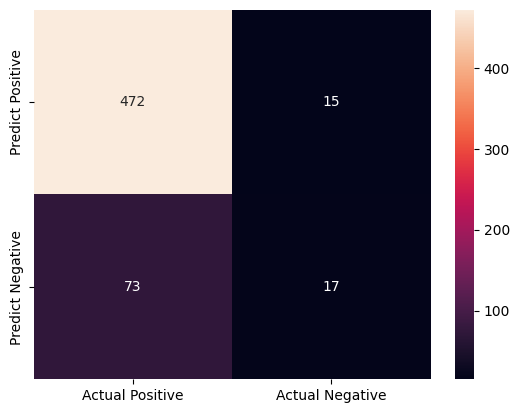

In [125]:
from sklearn.metrics import confusion_matrix
lg_cm = confusion_matrix(y_test, lg_pred)
print('Confusion matrix\n\n', lg_cm)
print('\nTrue Positives(TP) = ', lg_cm[0,0])
print('\nTrue Negatives(TN) = ', lg_cm[1,1])
print('\nFalse Positives(FP) = ', lg_cm[0,1])
print('\nFalse Negatives(FN) = ', lg_cm[1,0])
cm_matrix = pd.DataFrame(data=lg_cm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

## Naive Bayes

In [127]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [128]:
nb_pred = nb.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)
nb_prec = precision_score(y_test, nb_pred)
nb_rec = recall_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_pred)
print("Naive Bayes Accuracy: %.4f" % nb_acc)
print("Naive Bayes Precision: %.4f" % nb_prec)
print("Naive Bayes Recall: %.4f" % nb_rec)
print("Naive Bayes F1: %.4f" % nb_f1)
print("Naive Bayes AUC: %.4f" % nb_auc)
# Check for overfitting
print('Training set score: {:.4f}'.format(nb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(nb.score(X_test, y_test)))

Naive Bayes Accuracy: 0.7868
Naive Bayes Precision: 0.3740
Naive Bayes Recall: 0.5444
Naive Bayes F1: 0.4434
Naive Bayes AUC: 0.6880
Training set score: 0.7890
Test set score: 0.7868


In [129]:
scores = cross_val_score(nb, X_train, y_train, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean())) # the model has an average performance of 66%

Cross-validation scores:[0.81481481 0.75836431 0.79182156 0.79553903 0.15241636]
Average cross-validation score: 0.6626


Confusion matrix

 [[405  82]
 [ 41  49]]

True Positives(TP) =  405

True Negatives(TN) =  49

False Positives(FP) =  82

False Negatives(FN) =  41


<Axes: >

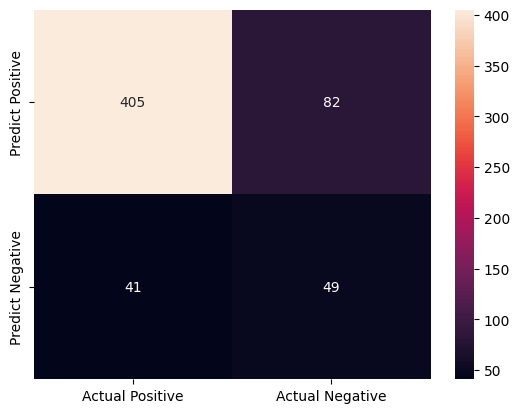

In [130]:
nb_cm = confusion_matrix(y_test, nb_pred)
print('Confusion matrix\n\n', nb_cm)
print('\nTrue Positives(TP) = ', nb_cm[0,0])
print('\nTrue Negatives(TN) = ', nb_cm[1,1])
print('\nFalse Positives(FP) = ', nb_cm[0,1])
print('\nFalse Negatives(FN) = ', nb_cm[1,0])
cm_matrix = pd.DataFrame(data=nb_cm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

## Decision Trees

In [158]:
tree_X_train, tree_X_test, tree_y_train, tree_y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

## HyperParameter Optimization

In [159]:
# Define the parameter grid to search
parameters = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 3, 5, 7],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}
grid_search = GridSearchCV(estimator = dt,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(tree_X_train, tree_y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [160]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV best score : 0.8522


Parameters that give the best results : 

 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Estimator that was chosen by the search : 

 DecisionTreeClassifier(criterion='entropy', max_depth=3)
GridSearch CV score on test set: 0.8440


c:\Users\Shaun Padrejuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [161]:
dt = grid_search.best_estimator_
dt_pred = dt.predict(tree_X_test)
dt_acc = accuracy_score(tree_y_test, dt_pred)
dt_prec = precision_score(tree_y_test, dt_pred)
dt_rec = recall_score(tree_y_test, dt_pred)
dt_f1 = f1_score(tree_y_test, dt_pred)
dt_auc = roc_auc_score(tree_y_test, dt_pred)
print("Decision Tree Accuracy: %.4f" % dt_acc)
print("Decision Tree Precision: %.4f" % dt_prec)
print("Decision Tree Recall: %.4f" % dt_rec)
print("Decision Tree F1: %.4f" % dt_f1)
print("Decision Tree AUC: %.4f" % dt_auc)
# Check for overfitting
print('Training set score: {:.4f}'.format(dt.score(tree_X_train, tree_y_train)))
print('Test set score: {:.4f}'.format(dt.score(tree_X_test, tree_y_test)))

Decision Tree Accuracy: 0.8250
Decision Tree Precision: 0.3830
Decision Tree Recall: 0.2000
Decision Tree F1: 0.2628
Decision Tree AUC: 0.5702
Training set score: 0.8707
Test set score: 0.8250


Confusion matrix

 [[458  29]
 [ 68  22]]

True Positives(TP) =  458

True Negatives(TN) =  22

False Positives(FP) =  29

False Negatives(FN) =  68


<Axes: >

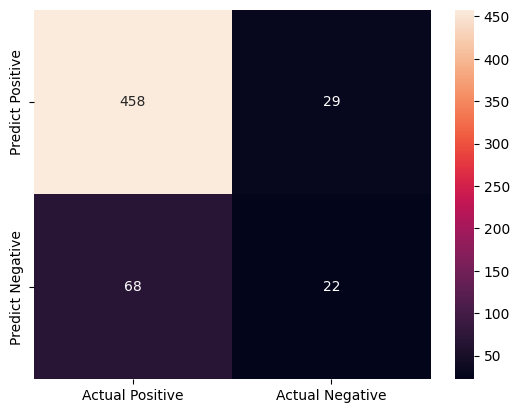

In [136]:
dt_cm = confusion_matrix(tree_y_test, dt_pred)
print('Confusion matrix\n\n', dt_cm)
print('\nTrue Positives(TP) = ', dt_cm[0,0])
print('\nTrue Negatives(TN) = ', dt_cm[1,1])
print('\nFalse Positives(FP) = ', dt_cm[0,1])
print('\nFalse Negatives(FN) = ', dt_cm[1,0])
cm_matrix = pd.DataFrame(data=dt_cm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

## K-Nearest Neighbors

In [151]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

## HyperParameter Optimization

In [152]:
def compute_optimal_n_neighbors(X, y, n_neighbors_range, cv=5, scoring='accuracy'):
    mean_scores = []
    for n_neighbors in n_neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_val_score(knn, X, y, cv=cv, scoring=scoring)
        mean_scores.append(np.mean(scores))
    optimal_n_neighbors = n_neighbors_range[np.argmax(mean_scores)]
    return optimal_n_neighbors, mean_scores
optimal_n_neighbors, mean_scores = compute_optimal_n_neighbors(X_train, y_train, n_neighbors_range=[3, 5, 7, 9, 11])
print("Optimal number of neighbors:", optimal_n_neighbors)
print("Mean cross-validation scores:", mean_scores)

Optimal number of neighbors: 5
Mean cross-validation scores: [0.8506650144568362, 0.8566157235302218, 0.8521547569874708, 0.8558804901555831, 0.8536527605672587]


In [154]:
from sklearn.datasets import load_iris
# Define the parameter grid to search
parameters = {
    'n_neighbors': [optimal_n_neighbors],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric used for the tree
}
grid_search = GridSearchCV(estimator = knn,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [155]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV best score : 0.8566


Parameters that give the best results : 

 {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


Estimator that was chosen by the search : 

 KNeighborsClassifier(metric='euclidean')
GridSearch CV score on test set: 0.8319


In [156]:
knn = grid_search.best_estimator_
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_prec = precision_score(y_test, knn_pred)
knn_rec = recall_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_pred)
print("k-Nearest Neighbors Accuracy: %.4f" % knn_acc)
print("k-Nearest Neighbors Precision: %.4f" % knn_prec)
print("k-Nearest Neighbors Recall: %.4f" % knn_rec)
print("k-Nearest Neighbors F1: %.4f" % knn_f1)
print("k-Nearest Neighbors AUC: %.4f" % knn_auc)
# Check for overfitting
print('Training set score: {:.4f}'.format(knn.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(knn.score(X_test, y_test)))

k-Nearest Neighbors Accuracy: 0.8319
k-Nearest Neighbors Precision: 0.4186
k-Nearest Neighbors Recall: 0.2000
k-Nearest Neighbors F1: 0.2707
k-Nearest Neighbors AUC: 0.5743
Training set score: 0.8804
Test set score: 0.8319


Confusion matrix

 [[462  25]
 [ 72  18]]

True Positives(TP) =  462

True Negatives(TN) =  18

False Positives(FP) =  25

False Negatives(FN) =  72


<Axes: >

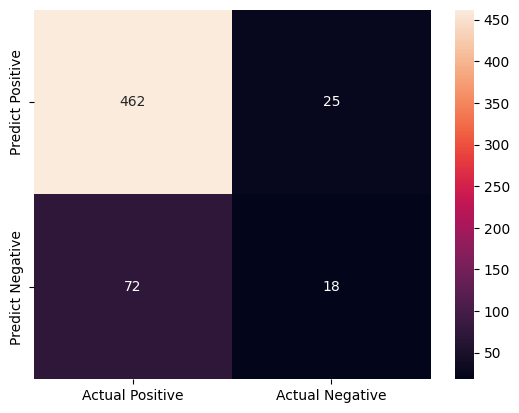

In [157]:
knn_cm = confusion_matrix(y_test, knn_pred)
print('Confusion matrix\n\n', knn_cm)
print('\nTrue Positives(TP) = ', knn_cm[0,0])
print('\nTrue Negatives(TN) = ', knn_cm[1,1])
print('\nFalse Positives(FP) = ', knn_cm[0,1])
print('\nFalse Negatives(FN) = ', knn_cm[1,0])
cm_matrix = pd.DataFrame(data=knn_cm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

## Support Vector Machines

In [146]:
from sklearn.svm import SVC
svm=SVC() 
svm.fit(X_train,y_train)

SVC()

## Hyperparameter Optimization

In [147]:
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]
grid_search = GridSearchCV(estimator = svm,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [148]:
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV best score : 0.8678


Parameters that give the best results : 

 {'C': 1000, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}


Estimator that was chosen by the search : 

 SVC(C=1000, degree=4, gamma=0.01, kernel='poly')
GridSearch CV score on test set: 0.8475


In [149]:
svm = grid_search.best_estimator_
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
svm_prec = precision_score(y_test, svm_pred)
svm_rec = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_pred)
print("Support Vector Machines Accuracy: %.4f" % svm_acc)
print("Support Vector Machines Precision: %.4f" % svm_prec)
print("Support Vector Machines Recall: %.4f" % svm_rec)
print("Support Vector Machines F1: %.4f" % svm_f1)
print("Support Vector Machines AUC: %.4f" % svm_auc)
# Check for overfitting
print('Training set score: {:.4f}'.format(svm.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svm.score(X_test, y_test)))

Support Vector Machines Accuracy: 0.8475
Support Vector Machines Precision: 0.5385
Support Vector Machines Recall: 0.1556
Support Vector Machines F1: 0.2414
Support Vector Machines AUC: 0.5655
Training set score: 0.8975
Test set score: 0.8475


Confusion matrix

 [[475  12]
 [ 76  14]]

True Positives(TP) =  475

True Negatives(TN) =  14

False Positives(FP) =  12

False Negatives(FN) =  76


<Axes: >

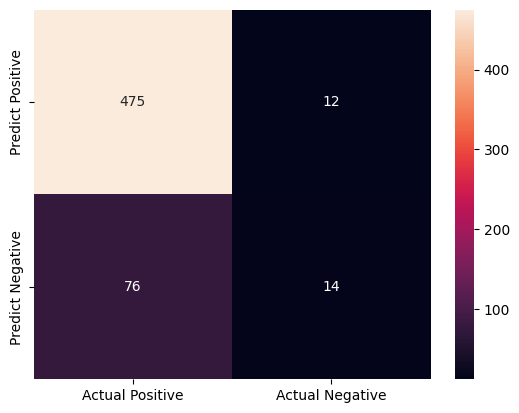

In [150]:
svm_cm = confusion_matrix(y_test, svm_pred)
print('Confusion matrix\n\n', svm_cm)
print('\nTrue Positives(TP) = ', svm_cm[0,0])
print('\nTrue Negatives(TN) = ', svm_cm[1,1])
print('\nFalse Positives(FP) = ', svm_cm[0,1])
print('\nFalse Negatives(FN) = ', svm_cm[1,0])
cm_matrix = pd.DataFrame(data=svm_cm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d')